In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy

tensor([-6.2832e+00, -6.0319e+00, -5.7805e+00, -5.5292e+00, -5.2779e+00,
        -5.0265e+00, -4.7752e+00, -4.5239e+00, -4.2726e+00, -4.0212e+00,
        -3.7699e+00, -3.5186e+00, -3.2673e+00, -3.0159e+00, -2.7646e+00,
        -2.5133e+00, -2.2619e+00, -2.0106e+00, -1.7593e+00, -1.5080e+00,
        -1.2566e+00, -1.0053e+00, -7.5398e-01, -5.0265e-01, -2.5133e-01,
         5.5806e-15,  2.5133e-01,  5.0265e-01,  7.5398e-01,  1.0053e+00,
         1.2566e+00,  1.5080e+00,  1.7593e+00,  2.0106e+00,  2.2619e+00,
         2.5133e+00,  2.7646e+00,  3.0159e+00,  3.2673e+00,  3.5186e+00,
         3.7699e+00,  4.0212e+00,  4.2726e+00,  4.5239e+00,  4.7752e+00,
         5.0265e+00,  5.2779e+00,  5.5292e+00,  5.7805e+00,  6.0319e+00])


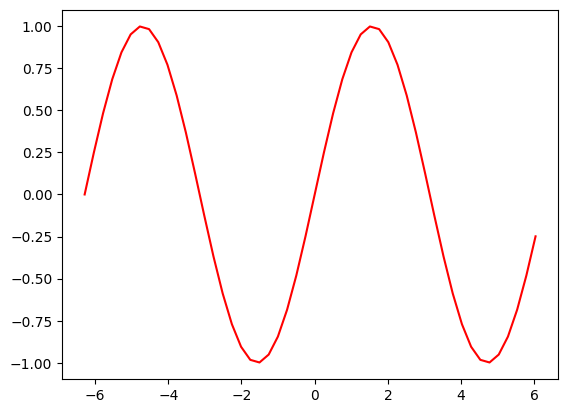

In [2]:
#常量都取出来，以便改动
EPOCH=1500
RNN_LR=0.01
left,right=-2,2
PI=math.pi
NUM=50


# x,y 是普通sinx 的torch tensor
x =torch.tensor([(num * PI)  for num in numpy.arange(left, right,(right-left)/NUM)],dtype=torch.float32)
print(x)
y = torch.sin(x)
plt.plot(x,y,color='red')
plt.show()

In [3]:
# rnn takes 3d input while mlp only takes 2d input
class RecNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn=torch.nn.LSTM(input_size=1,hidden_size=2,num_layers=1,batch_first=True)
        #至于这个线性层为什么是2维度接收，要看最后网络输出的维度是否匹配label的维度
        self.linear=torch.nn.Linear(2,1)
        
    def forward(self,x):
        # print("x shape: {}".format(x.shape))
        # x [batch_size, seq_len, input_size]
        output,hn=self.rnn(x)
        # print("output shape: {}".format(output.shape))
        # out [seq_len, batch_size, hidden_size]
        x=output.reshape(-1,2)
	
        # print("after change shape: {}".format(x.shape))
        x=self.linear(x)

        # print("after linear shape: {}".format(x.shape))

        return x

In [4]:
rnn=RecNN()
# input_x和labels是训练网络时候用的输入和标签。
input_x=x.reshape(-1, 1)
labels=y.reshape(-1,1)
input_x=input_x
labels=labels

#训练rnn
rnn_optimizer=torch.optim.Adam(rnn.parameters(),lr=RNN_LR)
rnn_loss=[]
for epoch in range(EPOCH):
    preds=rnn(input_x.unsqueeze(0))
    # print(x.unsqueeze(0).shape)
    # print(preds.shape)
    # print(labels.shape)
    loss=torch.nn.functional.mse_loss(preds,labels)

    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()
    rnn_loss.append(loss.item())

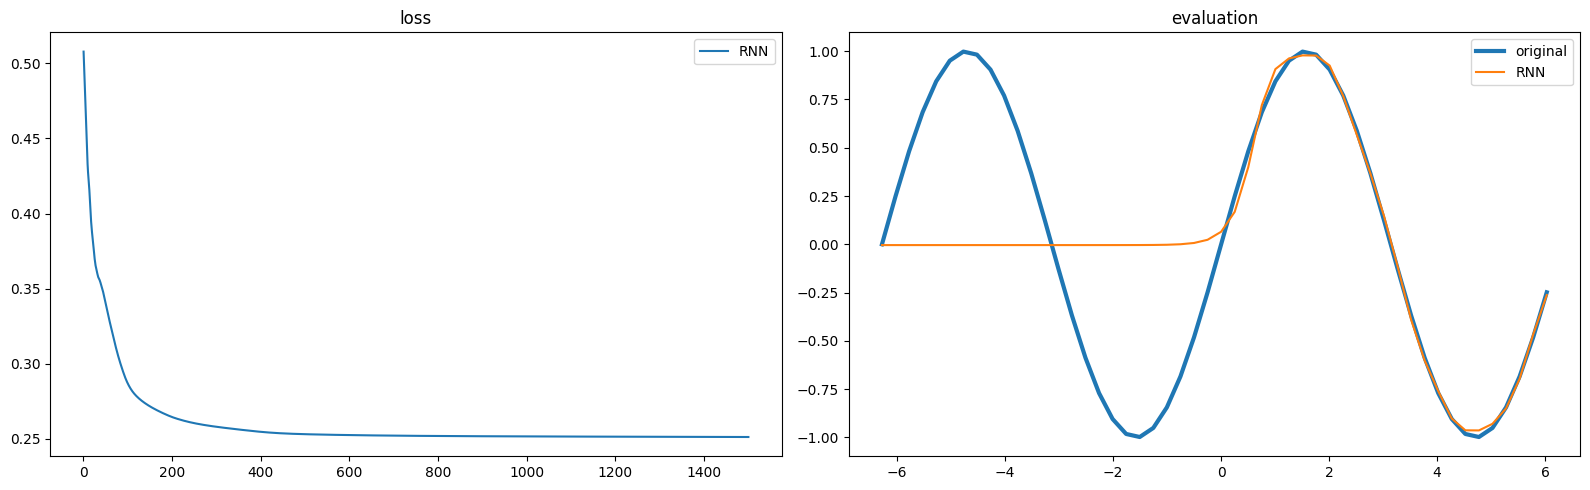

In [5]:
def PlotRNN(rnn, input_x, x):
    # input_x 是输入网络的x。
    # sin_x 是列表，x的取值，一维数据、
    # 虽然他们的内容（不是维度）是一样的。可以print shape看一下。
    rnn_eval = rnn.eval()
    # mlp_y_np=[]
    # rnn_y_np=[]
    rnn_y = rnn_eval(input_x.unsqueeze(0))
    # for i in range(rnn_y):
    #     rnn_y_np.append(i.detach().numpy())
    rnn_y_np=rnn_y.cpu().detach().numpy()

    plt.figure(figsize=(16, 5))

    plt.subplot(121)
    plt.plot([i + 1 for i in range(EPOCH)], rnn_loss, label='RNN')
    plt.title('loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(x, torch.sin(x), label="original", linewidth=3)
    plt.plot(x, [y[0] for y in rnn_y_np], label='RNN')
    plt.title('evaluation')
    plt.legend()

    plt.tight_layout()
    plt.show()

PlotRNN(rnn,input_x,x)

In [6]:
for name,para in rnn.named_parameters():
    print(name,para.numel(),para.data.tolist())

rnn.weight_ih_l0 8 [[2.625035047531128], [-0.7249592542648315], [0.6891963481903076], [-0.5797823667526245], [-0.47114142775535583], [0.36328551173210144], [1.4600085020065308], [3.6099536418914795]]
rnn.weight_hh_l0 16 [[2.6506221294403076, -0.9831904768943787], [1.2558553218841553, 2.582923650741577], [-1.2707008123397827, -1.3906784057617188], [0.8246764540672302, 1.8740818500518799], [0.13659954071044922, -1.0567545890808105], [0.0035582557320594788, 0.17878258228302002], [0.991969645023346, -0.8107866048812866], [1.9556777477264404, -0.5583682060241699]]
rnn.bias_ih_l0 8 [0.022704090923070908, 1.0519652366638184, 0.2139667123556137, 1.2832235097885132, 0.8107028007507324, -0.5598279237747192, -0.3648908734321594, -1.7633287906646729]
rnn.bias_hh_l0 8 [-0.8466810584068298, 0.3752472698688507, 0.1221335381269455, 1.3292005062103271, 0.9852778911590576, -0.016532696783542633, -0.36534208059310913, -1.2021931409835815]
linear.weight 2 [[0.1357535868883133, -0.859445333480835]]
linear.